# CGAN FASHION MNIST

## Requirement 

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Import

In [2]:
import torch
from torchvision.datasets import MNIST, FashionMNIST
import random
import torch
import torch.nn as nn
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [42]:
train_dataset = FashionMNIST(root='./Input/',train=True,download=True)

### Analyze

In [43]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./Input/
    Split: Train

In [44]:
# classes
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [54]:
# sample
img, label = train_dataset[35]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 8)

### Visualize

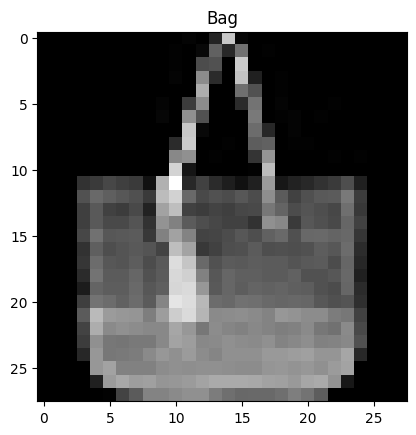

In [55]:
# single sample
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}");

### Transform

In [37]:
transforms_mnist = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
transforms_mnist

Compose(
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)

In [38]:
train_dataset = FashionMNIST(root='./input/',train=True, download=True,transform=transforms_mnist)

### Input information

In [39]:
img_dim = 100
BATCH_SIZE = 32
Image_size=28*28
class_label_size=10

### Dataloaders

In [40]:
data_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True)
len(data_loader)

1875

In [41]:
imgs, labels = next(iter(data_loader))
imgs.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Model

### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_label_size, class_label_size)
        
        self.model = nn.Sequential(
            nn.Linear(img_dim+class_label_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, Image_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

### Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_label_size, class_label_size)
        
        self.model = nn.Sequential(
            nn.Linear(Image_size+class_label_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

### Set up 

In [16]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


### Hyperpameter 

In [6]:
epochs =200
learming_rate = 0.0001
Times_train_discrimnizator=5

### Loss function

In [18]:
# Loss function
criterion = nn.BCELoss()

### Initialize 

In [19]:
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learming_rate)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learming_rate)

### Summary model

In [20]:
print(generator)

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [21]:
print(discriminator)

Discriminator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=794, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


## Training

In [22]:
def train_discriminator(real_images, labels):
    optimizer_D.zero_grad()
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(BATCH_SIZE).to(device))
    # train with fake images
    z = torch.randn(BATCH_SIZE, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, BATCH_SIZE)).to(device)
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(BATCH_SIZE).to(device))
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()
    return d_loss.item()

In [23]:
def train_generator():
    optimizer_G.zero_grad()
    z =torch.randn(BATCH_SIZE, 100).to(device)
    fake_labels = torch.LongTensor(np.random.randint(0, 10, BATCH_SIZE)).to(device)
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(BATCH_SIZE).to(device))
    g_loss.backward()
    optimizer_G.step()
    return g_loss.item()

In [24]:
d_loss_list=[]
g_loss_list=[]
for epoch in range(epochs):
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.to(device)
        labels = labels.to(device)
        generator.train()
        d_loss = 0
        for _ in range(Times_train_discrimnizator):
            d_loss = train_discriminator(real_images, labels)

        g_loss = train_generator()


    print(f"EPOCH: {epoch} | D_Loss: {d_loss:.5f} | G_Loss: {g_loss:.5f}")
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)


EPOCH: 0 | D_Loss: 0.00264 | G_Loss: 10.55459
EPOCH: 1 | D_Loss: 0.16806 | G_Loss: 6.62298
EPOCH: 2 | D_Loss: 0.11766 | G_Loss: 6.39251
EPOCH: 3 | D_Loss: 0.07573 | G_Loss: 5.06426
EPOCH: 4 | D_Loss: 0.14884 | G_Loss: 4.23625
EPOCH: 5 | D_Loss: 0.33836 | G_Loss: 3.43544
EPOCH: 6 | D_Loss: 0.21231 | G_Loss: 2.93144
EPOCH: 7 | D_Loss: 0.45368 | G_Loss: 2.06384
EPOCH: 8 | D_Loss: 0.49861 | G_Loss: 2.91726
EPOCH: 9 | D_Loss: 0.59238 | G_Loss: 2.08009
EPOCH: 10 | D_Loss: 0.37601 | G_Loss: 2.46274
EPOCH: 11 | D_Loss: 0.55882 | G_Loss: 2.51200
EPOCH: 12 | D_Loss: 0.44040 | G_Loss: 2.12907
EPOCH: 13 | D_Loss: 0.90888 | G_Loss: 1.72108
EPOCH: 14 | D_Loss: 0.61892 | G_Loss: 2.10599
EPOCH: 15 | D_Loss: 0.69786 | G_Loss: 1.73190
EPOCH: 16 | D_Loss: 0.63025 | G_Loss: 2.48770
EPOCH: 17 | D_Loss: 0.58024 | G_Loss: 2.26847
EPOCH: 18 | D_Loss: 0.56172 | G_Loss: 1.79508
EPOCH: 19 | D_Loss: 0.75819 | G_Loss: 2.04686
EPOCH: 20 | D_Loss: 0.50591 | G_Loss: 1.84057
EPOCH: 21 | D_Loss: 0.95697 | G_Loss: 1.618

### Plot loss

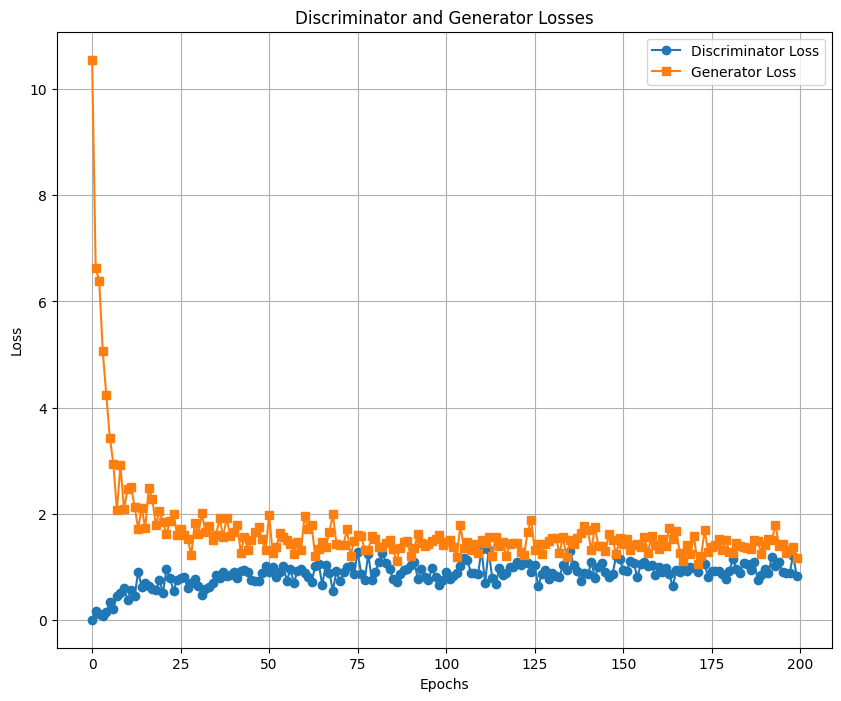

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(d_loss_list, label='Discriminator Loss', marker='o')
plt.plot(g_loss_list, label='Generator Loss', marker='s')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## Save the model

In [26]:

model_save_path = "./Output/"
model_name = f"cgan_fashion_mnist_e{epochs}.pt"
torch.save({"generator_state_dict": generator.state_dict(),"discriminator_state_dict": discriminator.state_dict()},os.path.join(model_save_path, model_name))

## Load the model

In [12]:
model_save_path = "./Output/"
model_trained = torch.load(os.path.join(model_save_path, "cgan_fashion_mnist_e200.pt"), map_location='cpu')

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [16]:
generator_loaded = Generator()
generator_loaded.load_state_dict(model_trained["generator_state_dict"])

<All keys matched successfully>

In [17]:
generator_loaded = generator_loaded.to('cpu');

## Test

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [33]:
noise_test = torch.randn(img_dim)
noise_test.unsqueeze_(dim=0)
print(noise_test.shape)
4
label=torch.LongTensor([8])
# input_=torch.cat([noise_test, label], 1)
print(label.shape)


torch.Size([1, 100])
torch.Size([1])


In [34]:
generator_loaded.eval()

with torch.inference_mode():
    gan_img_test = generator_loaded(noise_test,label)
    
gan_img_test.shape

torch.Size([1, 28, 28])

In [35]:
gan_img_test = gan_img_test.squeeze().reshape(28, 28).to('cpu').detach().numpy()

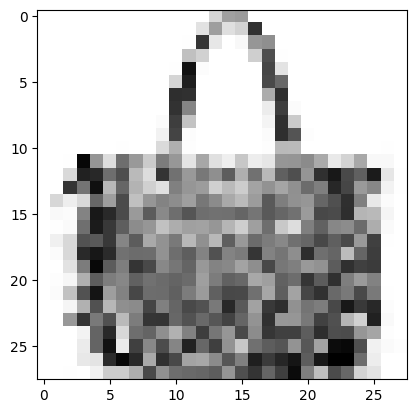

In [36]:
plt.imshow(gan_img_test, cmap='gray_r')